In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy import distance
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import censusgeocode as cg
from random import uniform
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

import warnings
warnings.filterwarnings('ignore')

In [2]:
center = (39.952,-75.164)

## Preparing data

In [3]:
with open("../data/yelp_dataset/yelp_academic_dataset_business21.json", "r") as f:
    yelp = pd.read_json(f, orient="records", lines=True)
with open("../data/yelp_dataset/yelp_academic_dataset_checkin.json", "r") as c:
    checkin = pd.read_json(c, orient="records", lines=True)
with open("../output/yelp_census_tract.csv", "r") as t:
    df = pd.read_csv(t)
with open("../output/cbd_census.csv", "r") as cen:
    df_c = pd.read_csv(cen)
cbd_census = df_c.tract.unique()

In [4]:
years = range(2011,2022)
def checkin_year(row,y):
    if str(y) in row['date']:
        return 1
    else:
        return 0
for y in years:
    #checkin.loc[:,'checkin_'+str(y)] = 0
    checkin['checkin_'+str(y)] = checkin.apply(lambda row: checkin_year(row,y), axis=1)

checkin.rename({'date':'checkin_date'},inplace=True,axis=1)
result = pd.merge(yelp, checkin, how = 'left', on=["business_id"])

philly = result[result.city=='Philadelphia']
philly.reset_index(drop=True,inplace=True)
philly = philly[(philly.latitude.notna()) & (philly.longitude.notna())]
center = (39.952,-75.164)
philly['distance'] = philly.apply(lambda x: distance.distance((x['latitude'], x['longitude']), center).km, axis=1) 
philly['is_cbd'] = philly.apply(lambda x: 1 if x['distance'] <= 2 else 0, axis=1) 
philly.drop(['address', 'state', 'city', 'hours','attributes'], axis=1, inplace=True)

for y in years[1:]:
    philly['close_%s'%(y)] = \
        philly.apply(lambda x: 
                1 if (x['checkin_%s'%(y-1)]==1 and x['checkin_%s'%(y)]==0) 
                else 0, axis=1) 
    philly['open_%s'%(y)] = \
        philly.apply(lambda x: 
                1 if (x['checkin_%s'%(y)]==1 and x['checkin_%s'%(y-1)]==0) 
                else 0, axis=1) 
                
status = philly[['close_%s'%(y) for y in years[1:]]+['open_%s'%(y) for y in years[1:]]]
philly=philly[(status == 1).any(axis=1)]
philly.reset_index(inplace=True,drop=True)

def count(status, year, df):
    count = df[status+'_'+str(year)].value_counts()[1]
    count_cbd = df[df[status+'_'+str(year)]==1].is_cbd.value_counts()[1]
    ratio = count_cbd/count * 100
    return count, count_cbd,ratio
    
status = philly[['close_%s'%(y) for y in years[1:]]+['open_%s'%(y) for y in years[1:]]]
philly=philly[(status == 1).any(axis=1)]
philly.reset_index(inplace=True,drop=True)
# join census tract with original data
use = df[['geoid', 'tract', 'block']]
philly_geo = philly.join(use)

def count(status, year, df):
    count = df[status+'_'+str(year)].value_counts()[1]
    count_cbd = df[df[status+'_'+str(year)]==1].is_cbd.value_counts()[1]
    ratio = count_cbd/count * 100
    return count, count_cbd,ratio

## Exploratory Data Analysis

### 1. Yelp data
(1) All businesses
(2) Food businesses

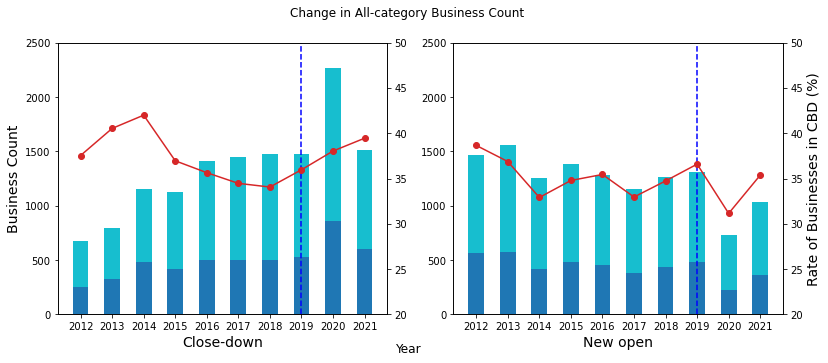

In [5]:
#(1)all businesses
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(121)
ax_o = fig.add_subplot(122)
ax.bar(years[1:],[count('close', y,philly)[0] for y in years[1:]],color="tab:cyan", width= 0.5 )
ax.bar(years[1:],[count('close', y,philly)[1] for y in years[1:]],color="tab:blue", width= 0.5 )
ax.set_xlabel("Close-down",fontsize=14)
ax.set_ylabel("Business Count",fontsize=14)
ax.set_ylim(0,2500)
ax2=ax.twinx()
ax2.plot(years[1:],[count('close', y,philly)[2] for y in years[1:]], color="tab:red",marker="o" )
ax2.set_ylim(20,50)
ax.set_xticks(years[1:], minor=False)
ax_o.bar(years[1:],[count('open', y,philly)[0] for y in years[1:]],color="tab:cyan", width= 0.5 )
ax_o.bar(years[1:],[count('open', y,philly)[1] for y in years[1:]],color="tab:blue", width= 0.5 )
ax_o.set_xlabel("New open",fontsize=14)
#ax_o.set_ylabel("Opened Businesses Count",fontsize=14)
ax_o.set_ylim(0,2500)
ax2=ax_o.twinx()
ax2.plot(years[1:],[count('open', y,philly)[2] for y in years[1:]], color="tab:red",marker="o" )
ax2.set_ylabel("Rate of Businesses in CBD (%)",fontsize=14)
ax2.set_ylim(20,50)
ax_o.set_xticks(years[1:], minor=False)

ax.vlines(2019, 0, 2500, linestyles='--', color='b')
ax_o.vlines(2019, 0, 2500, linestyles='--', color='b')

fig.suptitle(f'Change in All-category Business Count ')
fig.supxlabel('Year')
plt.savefig("../output/yelp.png")
plt.show()

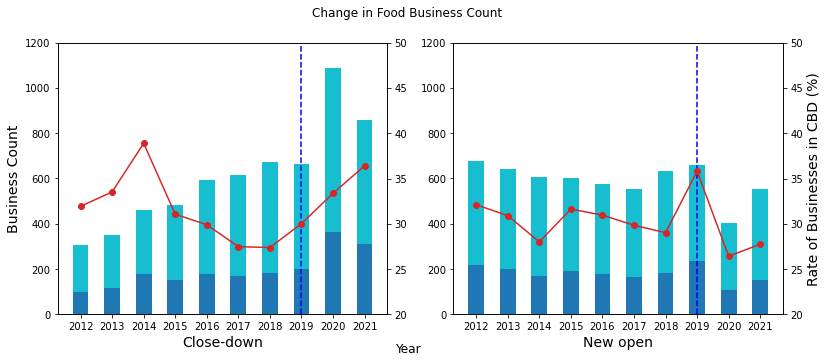

In [6]:
#(2) Food Businesses
food= philly_geo[philly_geo.categories.notna()][philly_geo[philly_geo.categories.notna()].categories.str.contains('food|restaurant|bar|cafe|Grocery', case=False)]
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(121)
ax_o = fig.add_subplot(122)
ax.bar(years[1:],[count('close', y,food)[0] for y in years[1:]],color="tab:cyan", width= 0.5 )
ax.bar(years[1:],[count('close', y,food)[1] for y in years[1:]],color="tab:blue", width= 0.5 )
ax.set_xlabel("Close-down",fontsize=14)
ax.set_ylabel("Business Count",fontsize=14)
ax.set_ylim(0,1200)
ax2=ax.twinx()
ax2.plot(years[1:],[count('close', y,food)[2] for y in years[1:]], color="tab:red",marker="o" )
ax2.set_ylim(20,50)
ax.set_xticks(years[1:], minor=False)
ax_o.bar(years[1:],[count('open', y,food)[0] for y in years[1:]],color="tab:cyan", width= 0.5 )
ax_o.bar(years[1:],[count('open', y,food)[1] for y in years[1:]],color="tab:blue", width= 0.5 )
ax_o.set_xlabel("New open",fontsize=14)
ax_o.set_ylim(0,1200)
ax2=ax_o.twinx()
ax2.plot(years[1:],[count('open', y,food)[2] for y in years[1:]], color="tab:red",marker="o" )
ax2.set_ylabel("Rate of Businesses in CBD (%)",fontsize=14)
ax2.set_ylim(20,50)
ax_o.set_xticks(years[1:], minor=False)

ax.vlines(2019, 0, 1200, linestyles='--', color='b')
ax_o.vlines(2019, 0, 1200, linestyles='--', color='b')

fig.suptitle(f'Change in Food Business Count ')
fig.supxlabel('Year')
plt.savefig("../output/yelp_food.png")
plt.show()

### 2.Business licenses data

In [7]:
shape_map_path = r"../data/business_licenses/business_licenses.shp"
shape_map = gpd.read_file(shape_map_path)
license = shape_map.to_crs(epsg=4326)  # EPSG 4326 = WGS84 = https://epsg.io/4326
food_l = license.licensetyp.str.contains('Food', case=False)
food_license = license[food_l]
food_license.reset_index(inplace=True, drop=True)
food_license.loc[:, 'longitude'] = food_license.geometry.x
food_license.loc[:, 'latitude'] = food_license.geometry.y
food_license['open'] = food_license.initialiss.str[:4]
food_license['close'] = food_license.inactiveda.str[:4]
food_license = food_license[(food_license.latitude.notna()) & (food_license.longitude.notna())]
food_license['distance'] = food_license.apply(lambda x: distance.distance((x['latitude'], x['longitude']), center).km, axis=1) 
food_license['is_cbd'] = food_license.apply(lambda x: 1 if x['distance'] <= 2 else 0, axis=1) 

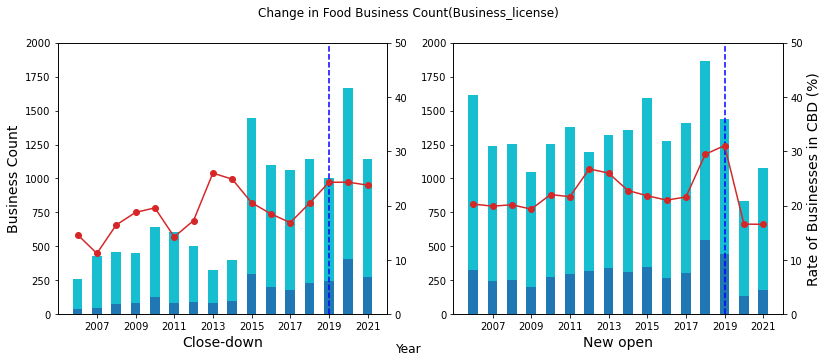

In [8]:
#use business license data
x = [i for i in range(2006,2022)]
y1_all = [len(food_license[food_license.close==str(y)]) for y in x]
y1_cbd = [sum(food_license[food_license.close==str(y)].is_cbd) for y in x]
y1_all.pop(6)
y1_all.insert(6, (y1_all[5]+y1_all[7])/2)
y1_cbd.pop(6)
y1_cbd.insert(6, (y1_cbd[5]+y1_cbd[7])/2)
y1 =[100*sum(food_license[food_license.close==str(y)].is_cbd)/len(food_license[food_license.close==str(y)])
        for y in x]
y2 = [100*sum(food_license[food_license.open==str(y)].is_cbd)/len(food_license[food_license.open==str(y)])
        for y in x]
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(121)
ax_o = fig.add_subplot(122)
ax.bar(x,y1_all,color="tab:cyan", width= 0.5 )
ax.bar(x,y1_cbd,color="tab:blue", width= 0.5 )

ax.set_xlabel("Close-down",fontsize=14)
ax.set_ylabel("Business Count",fontsize=14)
ax.set_ylim(0,2000)
ax2=ax.twinx()
ax2.plot(x,y1, color="tab:red",marker="o" )

ax2.set_ylim(0,50)
ax.set_xticks(x[1::2], minor=False)
ax_o.bar(x,[len(food_license[food_license.open==str(y)]) for y in x],color="tab:cyan", width= 0.5 )
ax_o.bar(x,[sum(food_license[food_license.open==str(y)].is_cbd) for y in x],color="tab:blue", width= 0.5 )
ax_o.set_xlabel("New open",fontsize=14)
ax_o.set_ylim(0,2000)
ax2=ax_o.twinx()
ax2.plot(x,y2, color="tab:red",marker="o" )
ax2.set_ylabel("Rate of Businesses in CBD (%)",fontsize=14)
ax2.set_ylim(0,50)
ax_o.set_xticks(x[1::2], minor=False)
ax.vlines(2019, 0, 2000, linestyles='--', color='b')
ax_o.vlines(2019, 0, 2000, linestyles='--', color='b')

fig.suptitle(f'Change in Food Business Count(Business_license)')
fig.supxlabel('Year')
plt.savefig("../output/licenses.png")
plt.show()

## Running Difference-in-Difference model

### With Yelp data

In [9]:
status_col =['close_%s'%(y) for y in years[1:]]+['open_%s'%(y) for y in years[1:]]
df_yelp =food[['tract','block', 'geoid','is_cbd','postal_code'] + status_col]
df_tract = df_yelp.groupby(['tract'])['close_2012',
 'close_2013','close_2014','close_2015','close_2016','close_2017','close_2018','close_2019','close_2020',
 'close_2021','open_2012','open_2013','open_2014','open_2015','open_2016','open_2017','open_2018','open_2019',
 'open_2020','open_2021'].apply(lambda x : x.astype(int).sum())
df_tract.reset_index(inplace=True)
df_tract = pd.wide_to_long(df_tract, ["close_", "open_"], i="tract", j="year")
df_tract.reset_index(inplace=True)

df_tract['is_cbd'] = df_tract.apply(lambda row: 1 if row.tract in cbd_census else 0,axis =1)
df_tract['post_covid'] = df_tract.apply(lambda x: 1 if x.year>=2020 else 0, axis=1)

#creating interaction variable
df_tract['DID'] = df_tract.apply( lambda x: 1 if (x['is_cbd']==1) and (x['post_covid']==1) else 0, axis=1)
# create log open count
df_tract['ln(New open)'] = np.log(df_tract.open_)
df_tract['ln(Close-down)'] = np.log(df_tract.close_)
df_tract.rename({'open_':'New open','close_':'Close-down'}, axis=1, inplace=True)

In [10]:
# fit model with open
x = df_tract.loc[:,['is_cbd', 'post_covid','DID']]
y = df_tract['New open']
model = LinearRegression().fit(x, y)
X2 = sm.add_constant(x)
est_o = sm.OLS(y, X2).fit(cov_type='HC2', use_t=None)
# fit model with log(open_count)
x = df_tract.loc[:,['is_cbd', 'post_covid','DID']][df_tract['ln(New open)']>=0]
y_ln = df_tract['ln(New open)'][df_tract['ln(New open)']>=0]
model_ln = LinearRegression().fit(x, y_ln)
X2 = sm.add_constant(x)
est_l_o = sm.OLS(y_ln, X2).fit(cov_type='HC2', use_t=None)
# fit model with close
x = df_tract.loc[:,['is_cbd', 'post_covid','DID']]
y = df_tract['Close-down']
model = LinearRegression().fit(x, y)
X2 = sm.add_constant(x)
est_c = sm.OLS(y, X2).fit(cov_type='HC2', use_t=None)
# fit model with log(close_count)
x = df_tract.loc[:,['is_cbd', 'post_covid','DID']][df_tract['ln(Close-down)']>=0]
y_ln = df_tract['ln(Close-down)'][df_tract['ln(Close-down)']>=0]
model_ln = LinearRegression().fit(x, y_ln)
X2 = sm.add_constant(x)
est_l_c = sm.OLS(y_ln, X2).fit(cov_type='HC2', use_t=None)

In [11]:
df_tract.to_csv('../output/yelp_ct.csv', index=False)

In [12]:
stargazer = Stargazer([est_o, est_l_o, est_c, est_l_c])
stargazer.title('Regression results')
stargazer.custom_columns(['New open', 'ln(New open)', 'Close-down','ln(Close-down)'], [1, 1,1,1])
stargazer.significant_digits(2)
stargazer.covariate_order(['DID', 'post_covid', 'is_cbd', 'const'])
stargazer.rename_covariates({'DID': 'Post Covid * CBD', 'is_cbd': 'CBD','const':'Constant','post_covid':'Post Covid'})
stargazer.show_degrees_of_freedom(False)
stargazer.add_custom_notes(['Data Source: Yelp.com(2022)'])
stargazer.cov_spacing = 2
stargazer

In [110]:
#print(stargazer.render_latex())

### With licenses data

In [13]:
df_use = food_license[['censustrac' , 'open', 'close', 'is_cbd']]
df_cen = pd.DataFrame(df_use.censustrac.value_counts())
df_cen.reset_index(inplace=True)
df_cen.rename({"index":"census_track", "censustrac": "count"}, inplace=True, axis=1)
cen_trac = df_use.censustrac.unique()
df_use['close'][df_use.close=='3013'] = '2013'

In [14]:
c_lst = []
for c in cen_trac:
    df = pd.DataFrame(df_use[df_use.censustrac==c].open.value_counts())
    df.reset_index(inplace=True)
    df.rename({"index":"year","open":"open_count"}, inplace=True, axis=1)
    df['census_track'] = c
    df['is_cbd'] = df_use[df_use.censustrac==c].is_cbd.max()
    
    c_lst.append(df)
data = pd.concat(c_lst, ignore_index=True)

data['post_covid'] = data.apply(lambda x: 1 if int(x.year)>=2020 else 0, axis=1)
#creating interaction variable
data['DID'] = data.apply( lambda x: 1 if (x['is_cbd']==1) and (x['post_covid']==1) else 0, axis=1)
# create log open count
data['open_ln'] = np.log(data.open_count)

census_dic = dict(data.census_track.value_counts())

c_lst = []
for c in cen_trac:
    df = pd.DataFrame(df_use[df_use.censustrac==c].close.value_counts())
    df.reset_index(inplace=True)
    df.rename({"index":"year","close":"close_count"}, inplace=True, axis=1)
    df['census_track'] = c
    df['is_cbd'] = df_use[df_use.censustrac==c].is_cbd.max()
    
    c_lst.append(df)
data2 = pd.concat(c_lst, ignore_index=True)
data2['post_covid'] = data2.apply(lambda x: 1 if int(x.year)>=2020 else 0, axis=1)

#creating interaction variable
data2['DID'] = data2.apply( lambda x: 1 if (x['is_cbd']==1) and (x['post_covid']==1) else 0, axis=1)
# create log open count
data2['close_ln'] = np.log(data2.close_count)

census_dic2 = dict(data2.census_track.value_counts())
data['census'] = data.apply(lambda x: str(int(float(x.census_track) * 100)), axis=1)
data2['census'] = data2.apply(lambda x: str(int(float(x.census_track) * 100)), axis=1)

data.rename({'open_count' :'New open'}, inplace=True,axis='columns')
data2.rename({'close_count' :'Close-down'}, inplace=True,axis='columns')
data.to_csv('../output/bl_ct.csv', index=False)
data2.to_csv('../output/bl_ct2.csv', index=False)

In [18]:
for k in data2['census_track'].unique():
    if census_dic2[k] <= 5:
        data2.drop(data2[data2['census_track'] == k].index, inplace = True)
for k in data['census_track'].unique():
    if census_dic[k] <= 20: #10
        data.drop(data[data['census_track'] == k].index, inplace = True)

In [20]:
# fit model 
x = data.loc[:,['is_cbd', 'post_covid','DID']]
y = data['New open']
#model = LinearRegression().fit(x, y)
X2 = sm.add_constant(x)
est_o = sm.OLS(y, X2).fit(cov_type='HC2', use_t=None)
# fit model with log(New open)
x = data.loc[:,['is_cbd', 'post_covid','DID']]
y_ln = data['open_ln']
model_ln = LinearRegression().fit(x, y_ln)
X2 = sm.add_constant(x)
est_l_o = sm.OLS(y_ln, X2).fit(cov_type='HC2', use_t=None)
# fit model 
x = data2.loc[:,['is_cbd', 'post_covid','DID']]
y = data2['Close-down']
model_ln = LinearRegression().fit(x, y)
X2 = sm.add_constant(x)
est_c = sm.OLS(y, X2).fit(cov_type='HC2', use_t=None)
# fit model with log(Close-down)
x = data2.loc[:,['is_cbd', 'post_covid','DID']]
y_ln = data2['close_ln']
model_ln = LinearRegression().fit(x, y_ln)
X2 = sm.add_constant(x)
est_l_c = sm.OLS(y_ln, X2).fit(cov_type='HC2', use_t=None)

In [21]:
stargazer = Stargazer([est_o, est_l_o, est_c, est_l_c])
stargazer.title('Regression results')
stargazer.custom_columns(['New Open', 'ln(New open)', 'Close-down','ln(Close-down)'], [1, 1,1,1])
stargazer.significant_digits(2)
stargazer.covariate_order(['DID', 'post_covid', 'is_cbd', 'const'])
stargazer.rename_covariates({'DID': 'Post Covid * CBD', 'is_cbd': 'CBD','const':'Constant','post_covid':'Post Covid'})
stargazer.show_degrees_of_freedom(False)
stargazer.add_custom_notes(['Data Source: Business Licenses - Philadelphia (2022)'])
stargazer.cov_spacing = 2
stargazer

In [111]:
#print(stargazer.render_latex())